# Detect cracks with a Keras image classifier and OpenCV morphological transformations

# Treament description

## Detect cracks with a Keras image classifier
The main steps are:

0. the dataset contains 2 subsets, one for the images with cracks, the other one for the images without crack
1. this dataset is reformated to {image, target}, where the target equals to positive (resp. negative) if the image contains crack (resp. the image does not contain crack)
2. the dataset is divided into [train, test and validation sets](#data_splitting)
3. the preceding datasets are [preprocessed](#data_preprocessing) using standardization and data augmentation
4. the [selected Keras model](#model_selection) (_cf. infra_) is [initially trained](#initial_tuning) and evaluated
5. the model is [fine tuned](#fine_tuning) and evaluated
6. the final model is used to [detect](#crack_detection) cracks on larger pictures using cropping.

### Implemented models:
- MobileNetV2
- InceptionResNetV2
- VGG16
- Xception
- NASNetMobile
- ResNet101V2

The best model is ResNet101V2.

## Detect cracks with OpenCV
OpenCV can be used in [several ways](#OpenCV_cc) to detect concrete cracks.

The method used here is basic, a [function](#morpho_func) combining different morphological transformations simply colors in red the interior of the crack.

This function is used to enhance the [detection](#crack_detection) function on larger images.

_N.B._ the threshold based on the gray level plays a important role in the crack detection, the coloring of the cracks is sensitive to this parameter.

## Mask generation for OpenCV semantic segmentation
The file format for semantic segmentation must be {image, mask}, the [masks are constructed](#mask_generation) simply calling the function described in the preceding paragraph.

## Packages, data & functions
### Import Packages

In [1]:
import os
cwd = os.getcwd()
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.preprocessing import image
# Define function to plot some images
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import cv2
from PIL import Image

#Mixed precision is useful if compute capability > 7
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from numpy.random import seed
seed(42)
tf.keras.utils.set_random_seed(42)

2023-06-20 08:30:29.421342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 08:30:29.764518: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 08:30:30.362179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-20 08:30:30.362312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


2023-06-20 08:30:31.589168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 08:30:31.656759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 08:30:31.656831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 08:30:31.657230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Overall Settings

In [2]:
TRAINING_EPOCHS = 2
FINE_TUNING_EPOCHS = 3
BATCH_SIZE = 32
unfreezing_ratio = 30

image_height = 224
image_width = 224


## Data loading

In [3]:
base_dir = "/home/philippe/development/python/concrete_cracks_semantic_segmentation/data"

base_dataset = image_dataset_from_directory(
    base_dir,
    image_size = (image_height, image_width),
    crop_to_aspect_ratio = True,
    shuffle = False,
    batch_size = 32)

Found 40000 files belonging to 2 classes.


2023-06-20 08:31:29.564617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 08:31:29.566214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 08:31:29.566290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 08:31:29.566329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [4]:
base_df = pd.DataFrame(base_dataset.file_paths.copy())
base_df.columns = ['fullpaths']
base_df['labels'] = base_df.apply(lambda x: base_dataset.class_names[1] if (base_dataset.class_names[1] in x.fullpaths)  else base_dataset.class_names[0], axis=1)
base_df['filepaths'] = base_df.apply(lambda x: str(x.fullpaths).replace(base_dir, ''), axis=1)

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
base_df.head(10)

fullpaths  \
0  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00001.jpg   
1  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00002.jpg   
2  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00003.jpg   
3  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00004.jpg   
4  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00005.jpg   
5  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00006.jpg   
6  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00007.jpg   
7  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00008.jpg   
8  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00009.jpg   
9  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/00010.jpg   

     labels            filepaths  
0  Negative  /Negative/00001.jpg  
1  Negative  /Negative/00002.jpg  
2  Negative  /Negative/00003.jpg  
3  Negative  /Negative/00004.jpg  
4  Negative  /Negative/00005.jpg  
5  Negative  /Negative/00006.jpg  
6  Negative  /Negative/00007.jpg  
7  Negative  /Negative/00008.jpg  
8  Negative  /Negative/00009.jpg  
9  Negative  /Negative/00010.jpg

Negative    20000
Positive    20000
Name: labels, dtype: int64


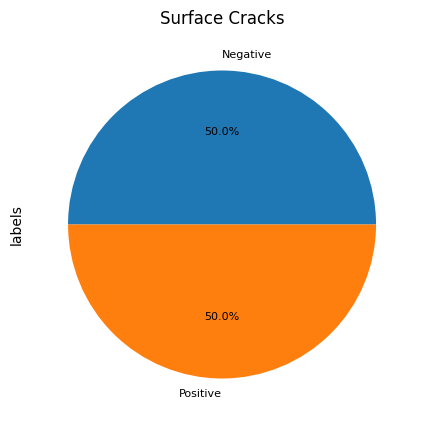

In [7]:
freq = base_df['labels'].value_counts()
print(freq)
freq.plot(kind='pie',figsize=(5,5),title='Surface Cracks',autopct='%1.1f%%',shadow = False,  fontsize=8);

<a id="data_splitting"></a>
## Data splitting

In [8]:
# 60% - train set,
# 20% - validation set,
# 20% - test set

train_df, valid_df, test_df = np.split(base_df.sample(frac=1, random_state=42), [int(.6*len(base_df)), int(.8*len(base_df))])

In [9]:
valid_df

fullpaths  \
17441    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/17442.jpg   
10156    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/10157.jpg   
7687     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/07688.jpg   
2629     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/02630.jpg   
7699     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Negative/07700.jpg   
...                                                                                                  ...   
35414  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Positive/15415_1.jpg   
25738    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Positive/05739.jpg   
32713  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Positive/12714_1.jpg   
21669    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Positive/01670.jpg   
30702  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data/Positive/10703_1.jpg   

         labels              filepaths  
17441  Negative    /Negative/17442.jpg  
10156  Negative    /Negative/10157.jpg  
7687   Negative    /Negative/07688.jpg  
2629   Negative    /Negative/02630.jpg  
7699   Negative    /Negative/07700.jpg  
...         ...                    ...  
35414  Positive  /Positive/15415_1.jpg  
25738  Positive    /Positive/05739.jpg  
32713  Positive  /Positive/12714_1.jpg  
21669  Positive    /Positive/01670.jpg  
30702  Positive  /Positive/10703_1.jpg  

[8000 rows x 3 columns]

<a id="data_preprocessing"></a>
## Data Augmentation
### Data Generators

For more information:
- [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)


In [10]:
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = True,
                         zoom_range      = 0.05,
                         rotation_range  = 25)
 

### Data agumentation and pre-processing using tensorflow on train set

In [11]:
train_generator = gen.flow_from_dataframe(
    train_df,
    directory = base_dir,
    x_col = 'fullpaths',
    y_col = 'labels',
    color_mode = "rgb",
    target_size = (image_height, image_width), 
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 24000 validated image filenames belonging to 2 classes.


### Data agumentation and pre-processing using tensorflow on test and validation sets

In [12]:
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df,
    directory   = base_dir, #
    x_col       = 'fullpaths',
    y_col       = 'labels',
    color_mode  ="rgb",
    target_size = (image_height, image_width), 
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    directory   = base_dir, 
    x_col       = 'fullpaths',
    y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (image_height, image_width), 
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False)

Found 8000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [13]:
# Get labels from dataset and store class names in a list
a = train_generator.class_indices
class_names = list(a.keys()) 

In [14]:
class_names

['Negative', 'Positive']

In [15]:
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])])    

### Sample Images

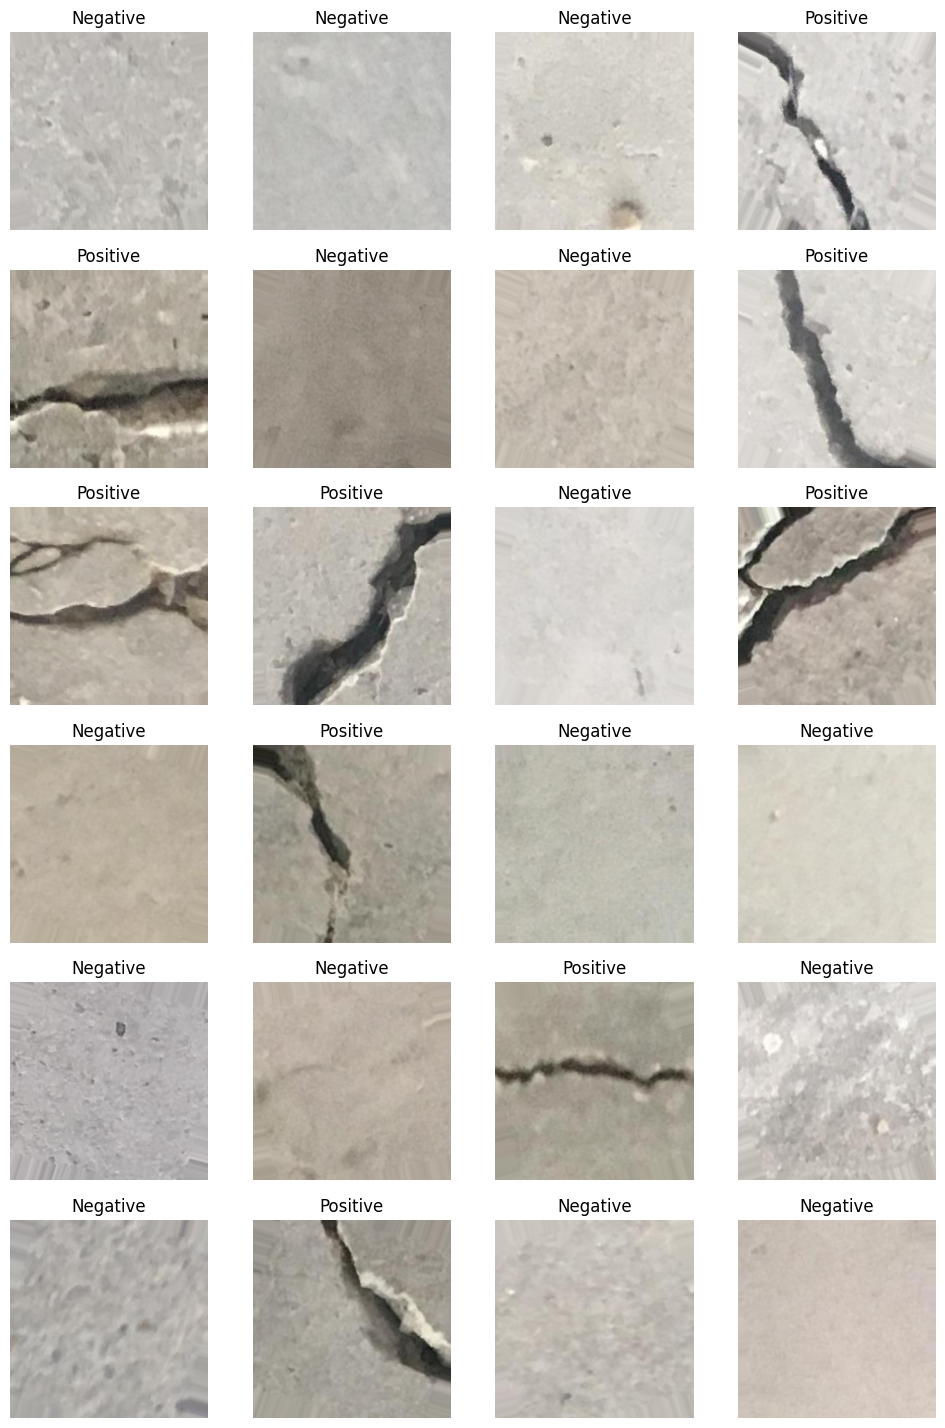

In [16]:
x,y = next(train_generator)
plot_images(x,y)

## Useful functions

### Modelling
#### Function to create model

In [17]:
def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'gelu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'gelu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

#### Function to fit model

In [18]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    # Call backs:
    # - early stopping
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.01,
                                              restore_best_weights = True)

    # - tensor board
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
    
    # - reduce on plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    # Defines how many layers to freeze during training depending on the size of the fine-tuning parameter.
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       
    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early, tensor_board, reduce_lr])
    
    return history

### Function to plot training history

In [19]:
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

### Function to plot confusion matrix

In [20]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

### Function to plot Grad-Cam heatmap

In [21]:
def make_gradcam_heatmap(image, model, last_conv_layer_name):
 
    img_array = tf.expand_dims(image, axis=0)
    
    # Remove last layer's softmax
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()  
    
    
     # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.jet

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255 

    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    # Restore last layer activation
    model.layers[-1].activation = last_layer_activation
    
    return superimposed_img

### Function to detect cracks on larger pictures

<a id="morpho_func"></a>
#### Function that detects cracks on tiles using morphological transformations

In [22]:
def detect_crack(image, threshold_gray=95, kernel_size=4, iterations=2, contour_thickness=2, debug=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, th1 = cv2.threshold(gray, threshold_gray, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    opening = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations=iterations)  # Use opening instead of closing because of inverted black/white

    contours, hierarchy = cv2.findContours(opening, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    mask = np.zeros_like(image)
    mask = cv2.drawContours(mask, contours, -1, (255, 255, 255), contour_thickness)
    mask = cv2.GaussianBlur(mask,(13,13),0)
    mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)[1]
    if debug == True:
       plt.imshow(mask)
       plt.show()       
    overlay = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Convert to BGR before drawing contours
    cont = cv2.drawContours(overlay, contours, -1, (255, 0, 0), contour_thickness)  # Draw contours with red color
    return cont, mask

In [23]:
def predict_cracks_on_tiles(input_image, height=100, width=100, height_src=image_height, 
                            width_src=image_width, threshold_gray=95, kernel_size=4, 
                            iterations=2, contour_thickness=2, with_cnn=True, debug=False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            shape_ini = a.shape # Save shape of the tile
            a = cv2.resize(a, (height_src, width_src)) # Resize the shape of the tile to the shape of the input layer
            if with_cnn == True:
                predicted_class = np.argmax(model.predict(np.array(a).reshape(1, height_src, width_src, 3)/255.0, verbose=0))
                ## Put predicted class on the image
                if predicted_class == 1:
                   a, _ = detect_crack(a, threshold_gray, kernel_size, iterations, contour_thickness, debug)
                   if debug == True:
                      plt.imshow(a)
                      plt.show()
                if predicted_class == 1:
                    color = (0,0, 255)
                else:
                    color = (0, 255, 0)
                b = np.zeros_like(a, dtype=np.uint8)
                b[:] = color
                add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            else:
                add_img, _ = detect_crack(a, threshold_gray, kernel_size, iterations, contour_thickness, debug)
                if debug == True:
                   plt.imshow(add_img)
                   plt.show()
            output_image[i:i+height, j:j+width,:] = cv2.resize(add_img, (shape_ini[1], shape_ini[0])) # reshape the tile to its initial shape
            k+=1
    plt.figure(figsize = (20,10))
    plt.imshow(output_image, aspect='auto')
    plt.show()

# Modelling & Evaluation
## [Base models](https://keras.io/api/applications/)
<a id="model_selection"></a>

In [24]:
mobilenetv2_base_model = tf.keras.applications.MobileNetV2(
                            alpha=1.0,
                            include_top=False,
                            weights="imagenet",
                            input_shape=(image_height, image_width, 3),
                            )
inceptionresnetv2_base_model = tf.keras.applications.InceptionResNetV2(
                         include_top = False,
                         weights = 'imagenet',
                         input_shape = (image_height, image_width, 3)
                         )

vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

xception_base_model = tf.keras.applications.xception.Xception(
                                 include_top = False,
                                 weights = 'imagenet',
                                 input_shape = (image_height, image_width, 3)
                                 )

nasnetmobile_base_model = tf.keras.applications.NASNetMobile(
                            input_shape=(image_height, image_width, 3),
                            include_top=False,
                            weights="imagenet",
                            )

resnet101v2_base_model = tf.keras.applications.ResNet101V2(
                            input_shape=(image_height, image_width, 3),
                            include_top=False,
                            weights="imagenet",
                            )



base_model = resnet101v2_base_model

## Initial tuning
<a id="initial_tuning"></a>

In [25]:
%%time 
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
model = create_model(base_model)
history = fit_model(model, base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/2


2023-06-20 08:32:36.846358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


750/750 [==============================] - 188s 237ms/step - loss: 0.0274 - accuracy: 0.9916 - val_loss: 0.0176 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 2/2
750/750 [==============================] - 179s 239ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0083 - val_accuracy: 0.9974 - lr: 0.0010
CPU times: user 6min 20s, sys: 18.7 s, total: 6min 38s
Wall time: 6min 8s


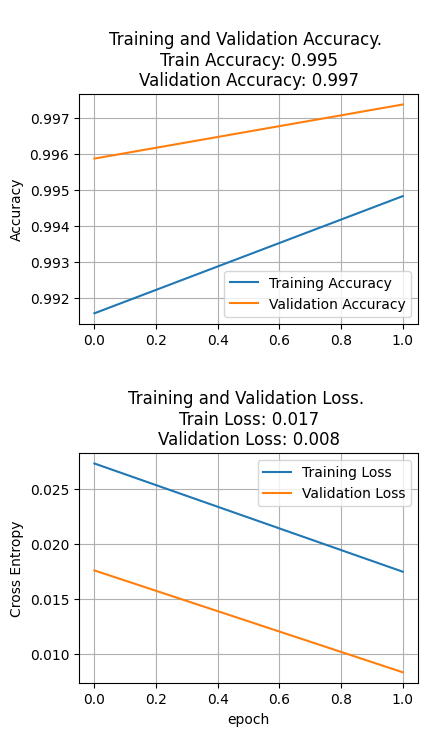

In [26]:
plot_history(history)

## Fine tuning
<a id="fine_tuning"></a>

In [27]:
%%time 
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
nr_base_layers = len(base_model.layers)
print("model base layers = ", nr_base_layers)    

history = fit_model(model, base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/unfreezing_ratio))

model base layers =  377
Unfreezing number of layers in base model =  12
Epoch 1/3
750/750 [==============================] - 181s 234ms/step - loss: 0.0191 - accuracy: 0.9947 - val_loss: 0.0093 - val_accuracy: 0.9979 - lr: 1.0000e-05
Epoch 2/3
750/750 [==============================] - 181s 241ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0078 - val_accuracy: 0.9980 - lr: 1.0000e-05
Epoch 3/3
750/750 [==============================] - 168s 223ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0073 - val_accuracy: 0.9983 - lr: 1.0000e-05
CPU times: user 9min 17s, sys: 28.2 s, total: 9min 46s
Wall time: 8min 50s


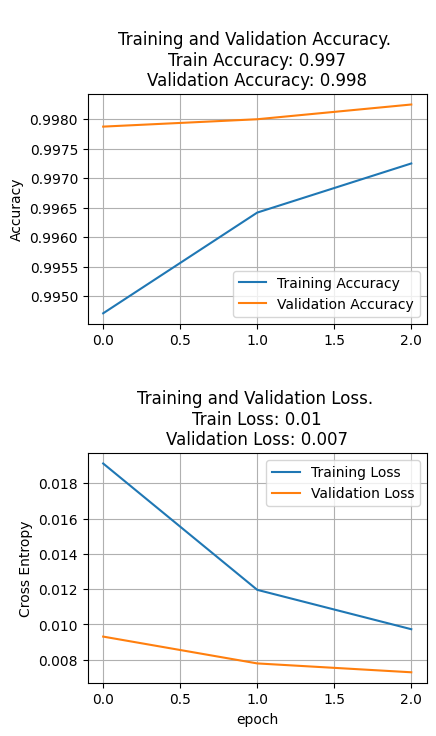

In [28]:
plot_history(history)

In [29]:
accuracy_score = model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

250/250 [==============================] - 23s 89ms/step - loss: 0.0073 - accuracy: 0.9983
[0.007290329318493605, 0.9982500076293945]
Accuracy: 99.83%
Loss: 0.007


In [30]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

test_preds = model.predict(test_generator)
test_pred_classes = np.argmax(test_preds, axis = 1)

250/250 [==============================] - 23s 86ms/step


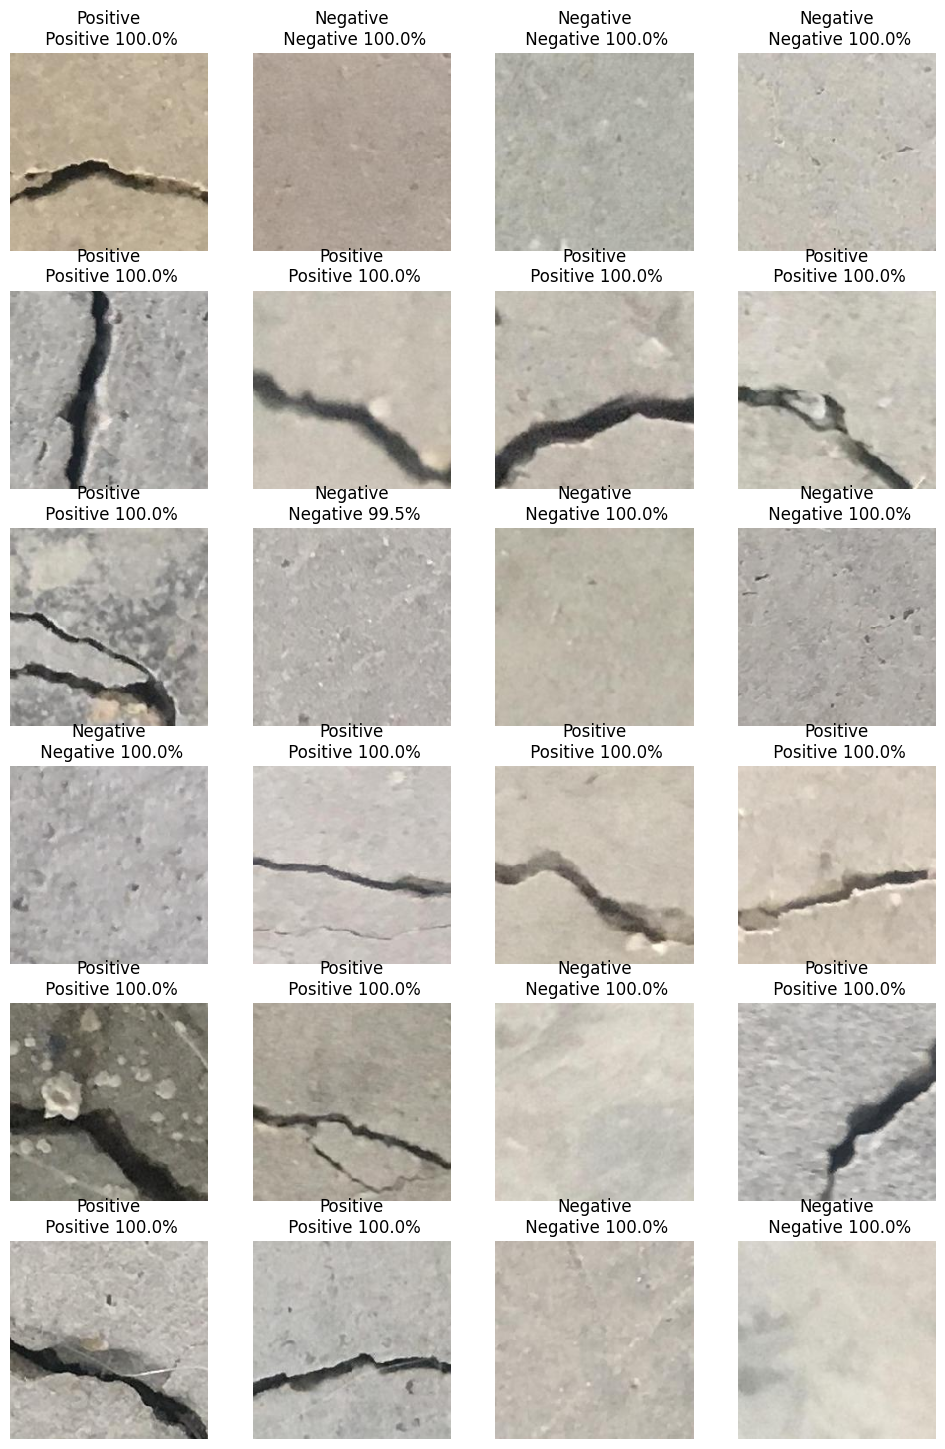

In [31]:
test_generator.reset()
x, y = next(test_generator)
plot_images(x, y, test_preds)

## Grad-Cam visualization

First search the last convolution layer

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

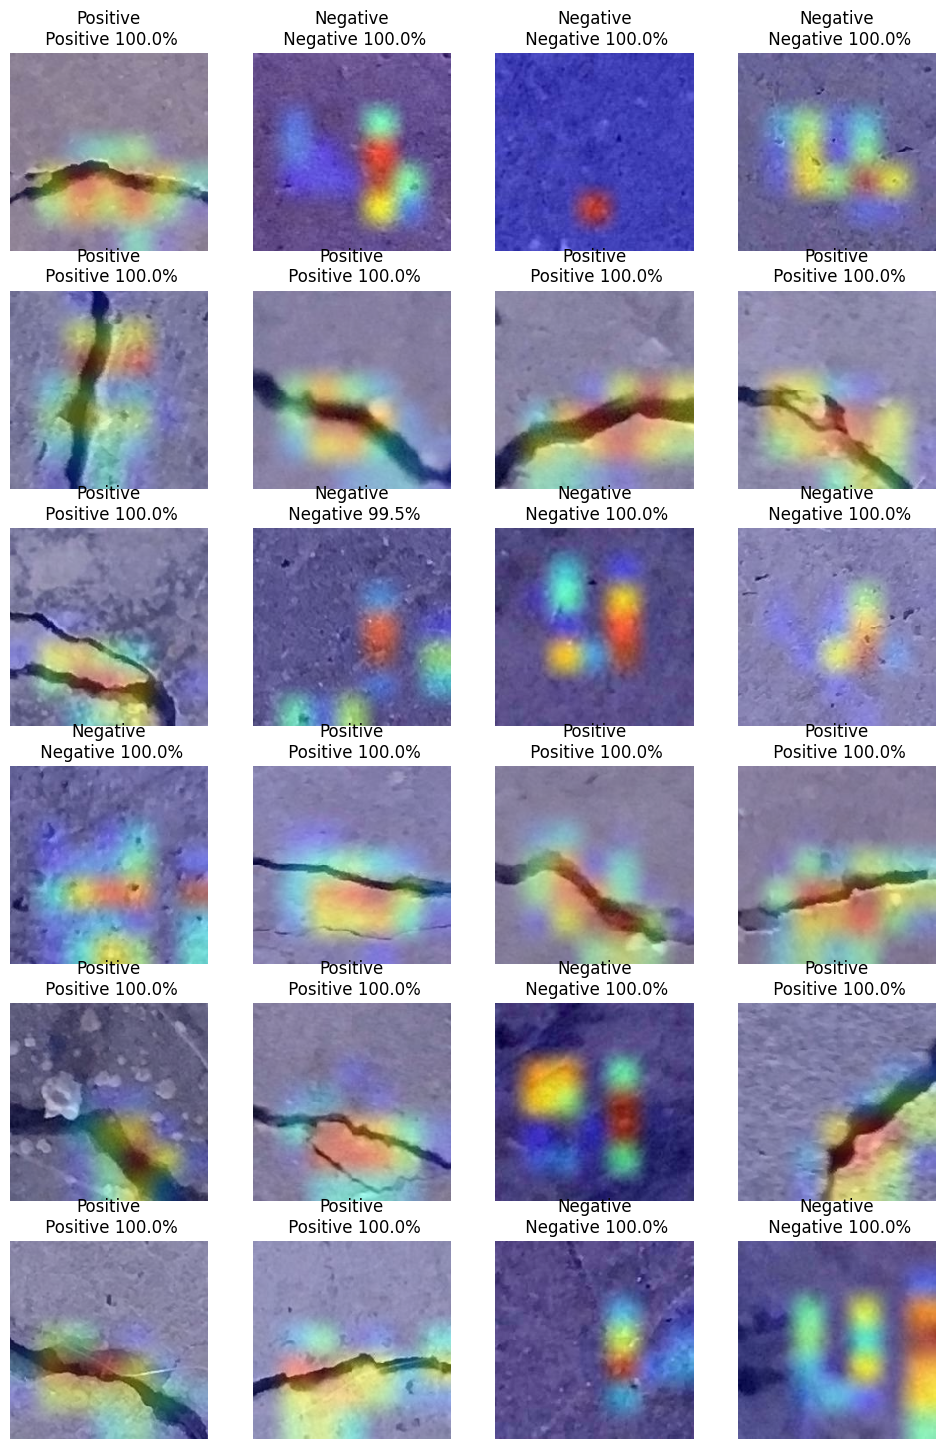

In [33]:
last_conv_layer_name = "conv5_block3_3_conv"

heatmaps = []

for img in x:
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
    heatmaps.append(heatmap)
    
plot_images(heatmaps, y, test_preds)

## Confusion Matrix & Classification Report

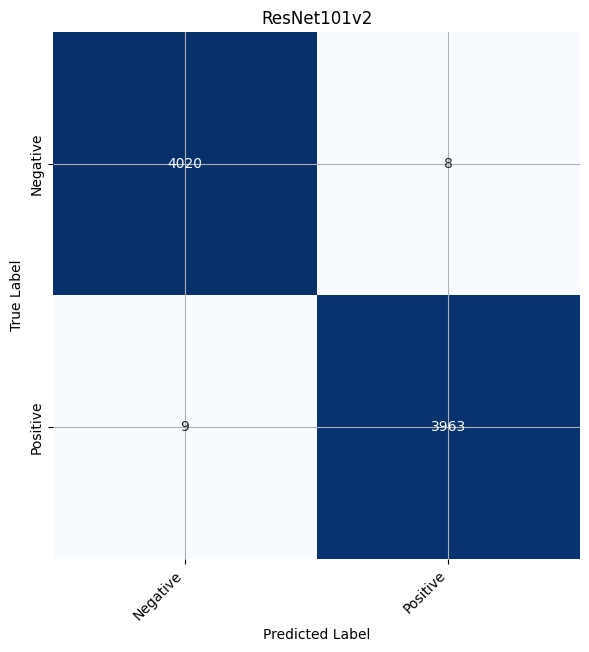

In [34]:
# Display confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

true_classes = test_generator.classes

plot_heatmap(true_classes, test_pred_classes, class_names, ax, title = "ResNet101v2")

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [35]:
print(classification_report(true_classes, test_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4028
    Positive       1.00      1.00      1.00      3972

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



### Save the model

In [ ]:
# model.save('./model')

<a id="crack_detection"></a>
# On larger pictures

### Load the model

In [ ]:
# model = keras.models.load_model('./model')

In [44]:
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/grunge-concrete-cement-wall-cracked-concrete.jpg'
#infile = '/home/philippe/development/concrete_cracks_semantic_segmentation/crack-695010_960_720.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/3632302149_9670ace43a_b.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/images_cracks.jpg'
infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/texture-993878_1280.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/IMG_20230611_174743.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/IMG_20230611_174749.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/IMG_20230611_174756.jpg'

## Predict cracks on tiles
### Only OpenCV morphological transformations

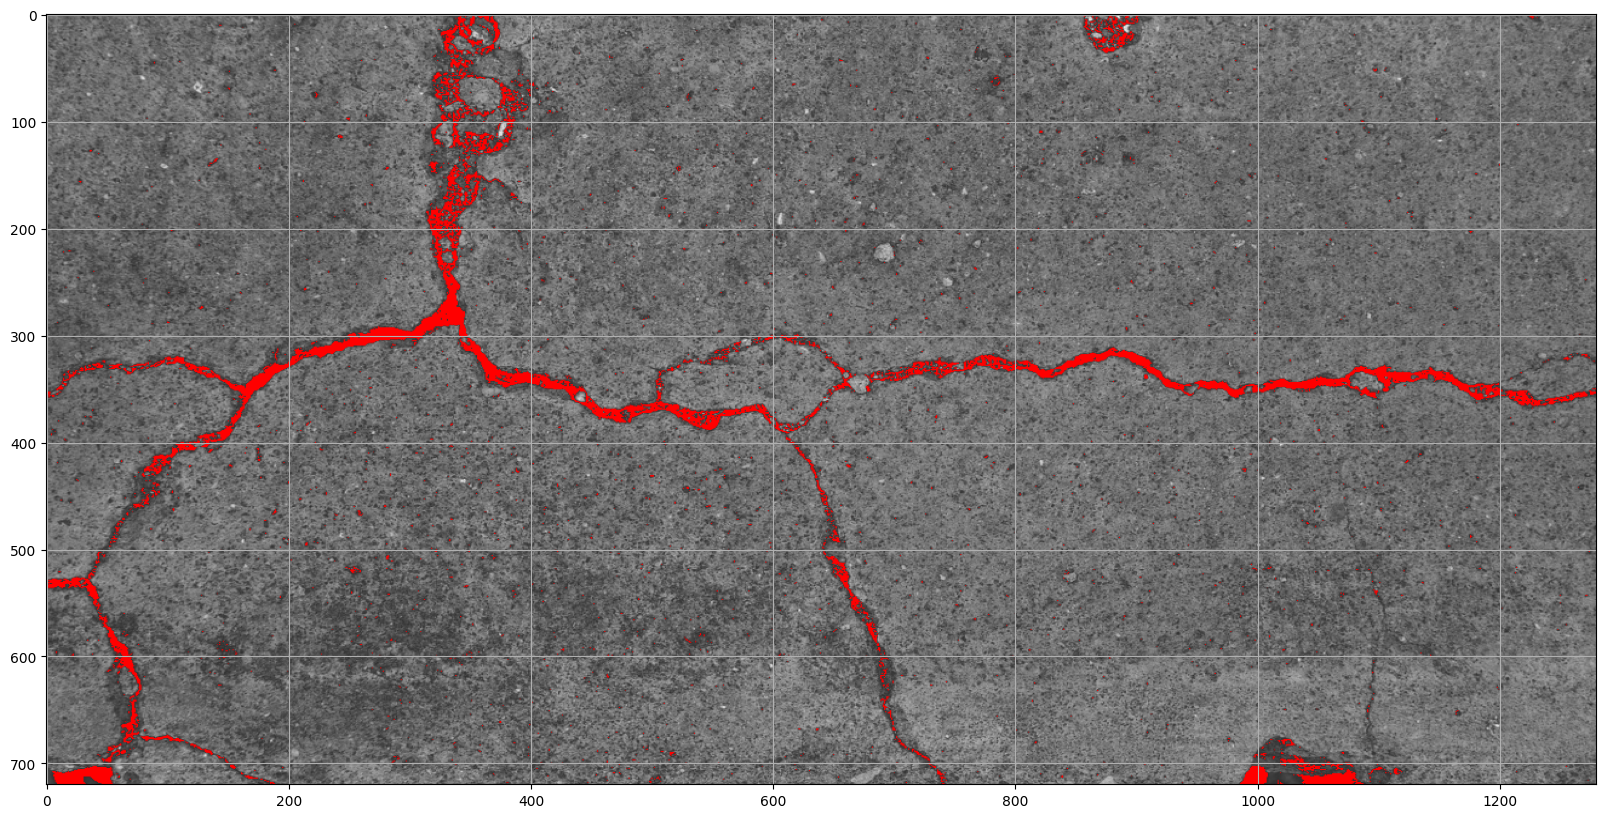

CPU times: user 752 ms, sys: 297 ms, total: 1.05 s
Wall time: 621 ms


In [45]:
%%time
predict_cracks_on_tiles(infile, 
                        height=100, width=100, # size of the tiles
                        height_src=image_height, width_src=image_width, # size of the pictures used for training
                        threshold_gray=48, # gray color limit
                        kernel_size=1, # size of the kernel user by morphological transformations
                        iterations=2, contour_thickness=cv2.FILLED, 
                        with_cnn=False, debug=False) 

### OpenCV morphological transformations with tile filtration based on Keras image classifier

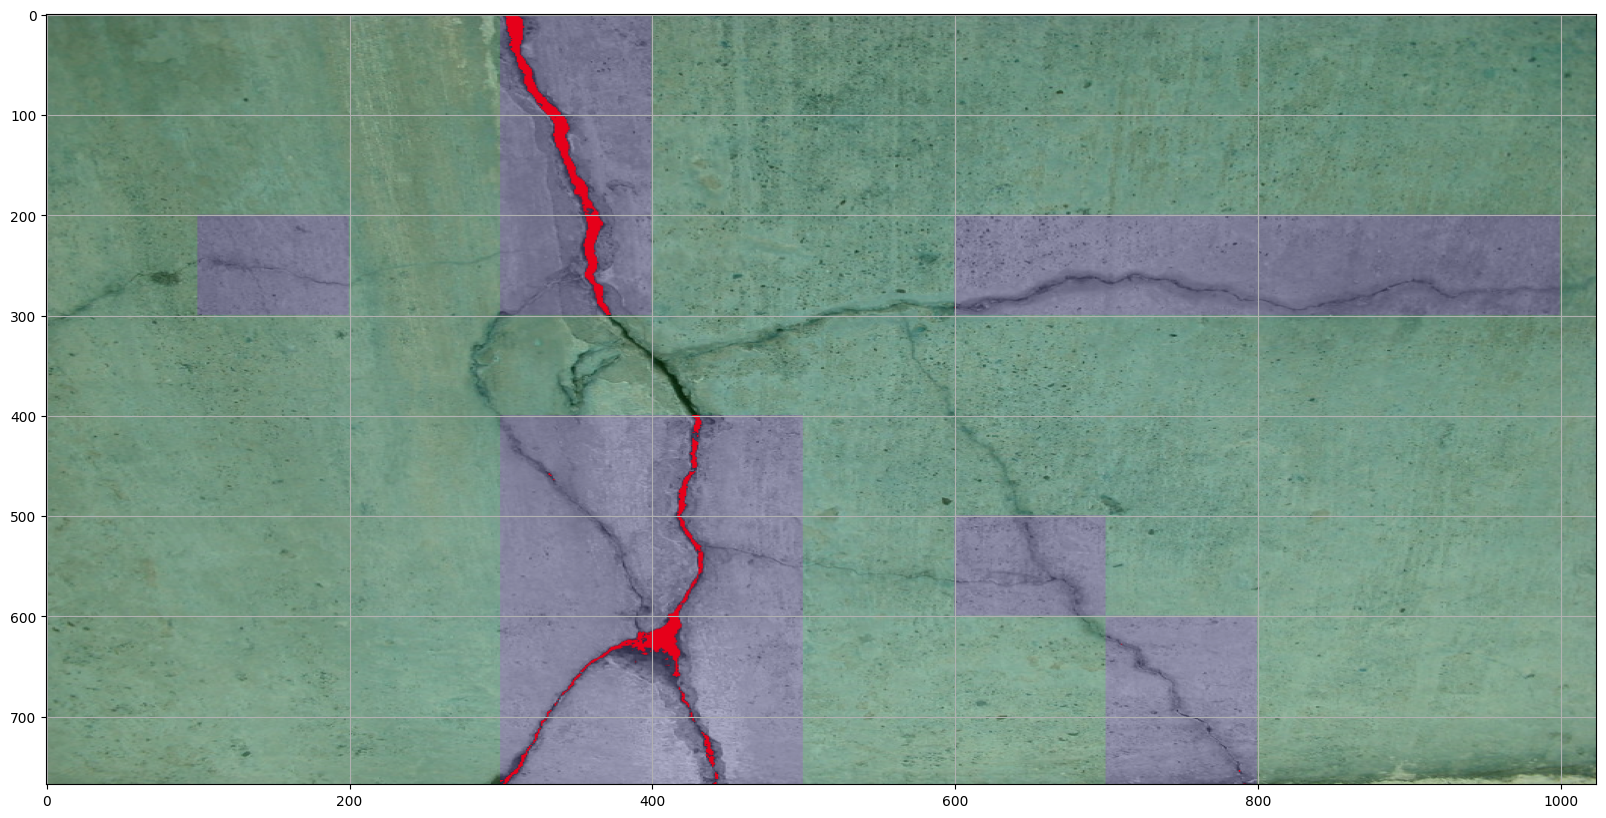

CPU times: user 6.65 s, sys: 435 ms, total: 7.09 s
Wall time: 6.7 s


In [38]:
%%time
predict_cracks_on_tiles(infile, 
                        height=100, width=100, # size of the tiles
                        height_src=image_height, width_src=image_width, # size of the pictures used for training
                        threshold_gray=48, # gray color limit
                        kernel_size=1, # size of the kernel user by morphological transformations
                        iterations=2, contour_thickness=cv2.FILLED, 
                        with_cnn=True, debug=False) 

# Mask generation
## Data preparation

### Copy Dataset

In [46]:
!rm -rf ./data_unet

In [47]:
!mkdir ./data_unet
!mkdir ./data_unet/image/
!mkdir ./data_unet/mask/

In [48]:
from pathlib import Path
import shutil

In [49]:
def copy_and_rename_p(src: str, dst: str):
    """copy and rename a file as new-<name>"""
    new_name = "p_" + Path(dst).name
    new_dst = Path(dst).with_name(new_name)
    shutil.copy2(src, new_dst)


In [50]:
shutil.copytree(
    "./data/Positive", "./data_unet/image/", copy_function=copy_and_rename_p, dirs_exist_ok=True
)

'./data_unet/image/'

In [51]:
def copy_and_rename_n(src: str, dst: str):
    """copy and rename a file as new-<name>"""
    new_name = "n_" + Path(dst).name
    new_dst = Path(dst).with_name(new_name)
    shutil.copy2(src, new_dst)


In [52]:
shutil.copytree(
    "./data/Negative", "./data_unet/image/", copy_function=copy_and_rename_n, dirs_exist_ok=True
)

'./data_unet/image/'

<a id="mask_generation"></a>
### Mask generation

In [53]:
path_folder = "./data_unet/image/"
img_list = os.listdir(path_folder)

In [54]:
for img in img_list:
    path_in = os.path.join(path_folder, img)
    if img[0] == 'p':
       img = cv2.imread(path_in, cv2.IMREAD_COLOR)
       _, mask = detect_crack(img, threshold_gray=48, kernel_size=1, iterations=2)
    else:
       mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.resize(mask, (224, 224))
    cv2.imwrite("./data_unet/mask/" + os.path.basename(path_in), mask)